# 02 - Topic Modeling

Author: Santosh Yadaw
Email: santoshyadawprl@gmail.com

## 1. Setup

In [1]:
# Imports
import os
import re
import string
import pandas as pd
import numpy as np

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from sklearn.cluster import KMeans, DBSCAN

import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
import hdbscan

In [2]:
# Constants
BASE_DIR = os.path.dirname(os.getcwd()) 
print(f"BASE_DIR: {BASE_DIR}")

DATA_FOLDER = os.path.join(BASE_DIR,"data", "raw")
print(f"DATA_FOLDER: {DATA_FOLDER}")

FINAL_DATA_FOLDER = os.path.join(BASE_DIR,"data", "processed")
print(f"FINAL_DATA_FOLDER: {FINAL_DATA_FOLDER}")

RAW_DATA_PATH = os.path.join(DATA_FOLDER, "DS2-assessment-simulated-employee-text.xlsx")
print(f"RAW_DATA_PATH: {RAW_DATA_PATH}")

FINAL_DATA_PATH = os.path.join(FINAL_DATA_FOLDER, "processed_data.csv")
print(f"FINAL_DATA_PATH: {FINAL_DATA_PATH}")

stop_words = set(stopwords.words('english'))

BASE_DIR: /home/jupyter/Topic-Review-Extraction-HR
DATA_FOLDER: /home/jupyter/Topic-Review-Extraction-HR/data/raw
FINAL_DATA_FOLDER: /home/jupyter/Topic-Review-Extraction-HR/data/processed
RAW_DATA_PATH: /home/jupyter/Topic-Review-Extraction-HR/data/raw/DS2-assessment-simulated-employee-text.xlsx
FINAL_DATA_PATH: /home/jupyter/Topic-Review-Extraction-HR/data/processed/processed_data.csv


## 2. Data Prep

In [3]:
# Read data
raw_data = pd.read_excel(RAW_DATA_PATH)
raw_data.head()

,unique_identifier,employee_feedback,department
0,3565,There's a culture of blame within the company ...,Dept A
1,7323,The company's approach to feedback and perform...,Dept A
2,5008,"While page limits have been set, some departme...",Dept A
3,3460,na,Dept A
4,2179,The culture of collaboration within our team i...,Dept A


In [4]:
# Initialise the wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

def process_text(text):
    # 1. Convert to lower case
    text = text.lower()

    # 2. Remove any digits and words containing digits
    text = ' '.join([word for word in text.split() if not any(c.isdigit() for c in word)])

    # 3. Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Remove unicode characters
    text = text.encode("ascii", "ignore").decode()
    
    # 5. Remove extrace spaces
    text = re.sub(' +', ' ', text).strip()

    # 6. Remove stop words in English
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # 7. Lemmatize the words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized_tokens)

# Apply processing function
raw_data['clean_employee_feedback'] = raw_data['employee_feedback'].apply(process_text)

In [5]:
# Remove any samples with less than 1 words
raw_data["word_count"] = raw_data['employee_feedback'].apply(lambda x : len(x.split()))
data_final = raw_data[raw_data["word_count"] > 2]
data_final

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count
0,3565,There's a culture of blame within the company ...,Dept A,there culture blame within company make diffic...,25
1,7323,The company's approach to feedback and perform...,Dept A,company approach feedback performance review g...,85
2,5008,"While page limits have been set, some departme...",Dept A,page limit set department ignoring still long ...,31
4,2179,The culture of collaboration within our team i...,Dept A,culture collaboration within team truly someth...,57
5,6830,While the workload can be overwhelming at time...,Dept A,workload overwhelming time appreciate company ...,36
...,...,...,...,...,...
150,7590,Our documentation is thorough. Onboarding new ...,Dept D,documentation thorough onboarding new member q...,14
151,4622,Feedback flows freely. Suggestions to improve ...,Dept D,feedback flow freely suggestion improve seen o...,12
152,2635,Our team leads by example. The standards they ...,Dept D,team lead example standard set motivate excel,13
153,3272,Cross-training and job shadowing help broaden ...,Dept D,crosstraining job shadowing help broaden skill...,16


In [6]:
# Remove any feedback which contains word like nan or na
data_final[(data_final["clean_employee_feedback"] != "nan") | (data_final["clean_employee_feedback"] != "na") | (data_final["clean_employee_feedback"] != "none") | (data_final["clean_employee_feedback"] != "nil")]

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count
0,3565,There's a culture of blame within the company ...,Dept A,there culture blame within company make diffic...,25
1,7323,The company's approach to feedback and perform...,Dept A,company approach feedback performance review g...,85
2,5008,"While page limits have been set, some departme...",Dept A,page limit set department ignoring still long ...,31
4,2179,The culture of collaboration within our team i...,Dept A,culture collaboration within team truly someth...,57
5,6830,While the workload can be overwhelming at time...,Dept A,workload overwhelming time appreciate company ...,36
...,...,...,...,...,...
150,7590,Our documentation is thorough. Onboarding new ...,Dept D,documentation thorough onboarding new member q...,14
151,4622,Feedback flows freely. Suggestions to improve ...,Dept D,feedback flow freely suggestion improve seen o...,12
152,2635,Our team leads by example. The standards they ...,Dept D,team lead example standard set motivate excel,13
153,3272,Cross-training and job shadowing help broaden ...,Dept D,crosstraining job shadowing help broaden skill...,16


In [7]:
# Save as final data
data_final.to_csv(FINAL_DATA_PATH, index=False)

## 3. Modeling

### 3.1 Latent Dirichlet Allocation (LDA)

A popular method for topic method that helps identify overarching topics in the entire dataset

#### 3.1.1 All response LDA

In [8]:
dictionary = Dictionary(data_final['clean_employee_feedback'].str.split())
corpus = [dictionary.doc2bow(text.split()) for text in data_final['clean_employee_feedback']]
lda = LdaModel(corpus, id2word=dictionary, num_topics=5) # adjust num_topics based on your needs

# Displaying topics
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"feel" + 0.017*"work" + 0.014*"team" + 0.014*"like" + 0.011*"would" + 0.009*"still" + 0.009*"make" + 0.009*"help" + 0.008*"company" + 0.008*"manager"
Topic: 1 
Words: 0.017*"work" + 0.017*"company" + 0.014*"feel" + 0.011*"feedback" + 0.011*"like" + 0.008*"opportunity" + 0.008*"process" + 0.008*"make" + 0.007*"employee" + 0.007*"would"
Topic: 2 
Words: 0.012*"work" + 0.011*"team" + 0.008*"career" + 0.008*"employee" + 0.007*"communication" + 0.007*"make" + 0.007*"within" + 0.007*"difficult" + 0.006*"respected" + 0.006*"leadership"
Topic: 3 
Words: 0.018*"company" + 0.013*"employee" + 0.013*"feel" + 0.010*"team" + 0.010*"however" + 0.009*"work" + 0.009*"job" + 0.008*"would" + 0.007*"good" + 0.007*"lack"
Topic: 4 
Words: 0.045*"company" + 0.024*"work" + 0.019*"feel" + 0.013*"feedback" + 0.011*"would" + 0.011*"employee" + 0.010*"manager" + 0.008*"like" + 0.008*"appreciate" + 0.008*"worklife"


#### Obeservations:
1. Topic 0:
- Words: feel, work, team, like, would, still, make, help, company and manager
- Potential Interpretation: This topic seems to appear to be about dfeedback and opportunities within the company. Employees might be discussing about the feedback process, potential groiwth and development opportunities and how they feel about these processes.

2. Topic 1:
- Words: work, company, feel, feedback, like, opportunity, process, make , employee and would
- Potential Interpretation: This topic leans sentiments about the companieis processes and feedback mechanisms. Feelings and opinions about working in the company and the opportunities (or lack thereof) available to the employees.

Topic 2:
- Words: work, team, career, employeee, communication, make, within, difficult, respected, leadership
- Potential Interpretation: This topic emphasizes on the concerns or comments about career growth and opportunities within the team. Challenges in communication, possible with leadership and how respected or valued the employees feel

Topic 3:
- Words: company, employee, feel, team, however, work, job, would, good and lack

- Potential Interpretation: This topic seems to have a contrasting sentiment where there are some good and some lacking aspects to the job -> keyword is however

Topic 4:
- Words: company, work, feel, feedback, would, employee, manager, like, appreciate and worklife

- Potential Interpretation: This topic suggests recognition and appreciation within the company. The term "appreciate" stands out, implying that employees are talking about recognition or the lack of it. "Feedback" and "team" further reinforce the theme of team dynamics and recognition.

Overall Takeaways:

1. Employee sentiment ("feel", "like") is a recurring theme across multiple topics, indicating it's a significant aspect of the survey responses.
2. The company's environment, expectations, feedback mechanisms, managerial interactions, and recognition are primary concerns or discussion areas among employees.

While the LDA model provides these groupings, it's essential to delve deeper into the actual responses to understand context and nuances. Moreover, combining this quantitative topic modeling with qualitative analyses can give a comprehensive view of the employee sentiment.
Remember, while the topics generated by LDA provide valuable insight, they should be treated as starting points. The actual survey responses, combined with domain knowledge and further qualitative analysis, will yield the most comprehensive insights.

#### 3.1.2 LDA by Department

For specific concerns by different departments, we can segment the data by department and conduct topic modeling (LDA) for each

In [9]:
departments = data_final['department'].unique()

for dept in departments:
    dept_df = data_final[data_final['department'] == dept]
    dept_corpus = [dictionary.doc2bow(text.split()) for text in dept_df['clean_employee_feedback']]
    
    dept_lda = LdaModel(dept_corpus, id2word=dictionary, num_topics=5) # adjust num_topics if needed
    
    print(f"\nTopics for department {dept}:")
    for idx, topic in dept_lda.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))


Topics for department Dept A:
Topic: 0 
Words: 0.013*"work" + 0.009*"concern" + 0.009*"leader" + 0.009*"acknowledging" + 0.005*"make" + 0.005*"company" + 0.005*"feel" + 0.005*"employee" + 0.005*"however" + 0.005*"like"
Topic: 1 
Words: 0.018*"company" + 0.013*"work" + 0.012*"package" + 0.012*"benefit" + 0.009*"feel" + 0.008*"employee" + 0.008*"make" + 0.008*"ie" + 0.005*"improvement" + 0.005*"review"
Topic: 2 
Words: 0.019*"company" + 0.015*"feedback" + 0.009*"difficult" + 0.007*"progress" + 0.007*"question" + 0.007*"allowing" + 0.007*"giving" + 0.007*"make" + 0.007*"performance" + 0.007*"would"
Topic: 3 
Words: 0.019*"company" + 0.018*"work" + 0.013*"manager" + 0.012*"feedback" + 0.011*"workload" + 0.009*"feel" + 0.008*"commitment" + 0.008*"balance" + 0.008*"appreciate" + 0.008*"worklife"
Topic: 4 
Words: 0.021*"company" + 0.012*"could" + 0.010*"investment" + 0.010*"like" + 0.009*"employee" + 0.008*"still" + 0.008*"idea" + 0.008*"would" + 0.007*"area" + 0.007*"competitive"

Topics fo

#### Observations

Interpreting the topics produced by LDA model in the context of different departments can provide insights about the sentiments and concerns , and themes particular to each deparment

1. Department: Dept A

- Topic 0: Concerns about leadership acknowledging employees' efforts and concerns. Sentiments about how employees feel in the work environment.

- Topic 1: A focus on the benefits and packages offered by the company. Possible feedback about compensation and areas of improvement.

- Topic 2: Feedback about company performance reviews. There might be challenges in getting or giving feedback, and there could be concerns about progress and performance evaluations.

- Topic 3: Workload balance and work-life balance seem to be of importance. There's appreciation for some aspects, but feedback about managers might also be significant.

- Topic 4: Discussions about the company's investments in certain areas and how competitive they are. A hint at potential suggestions or areas of improvement.

2. Department: Dept B

- Topic 0: Sentiments about transparency within the company. Employees may want to see more openness, possibly in decision-making or communication.

- Topic 1: Diverse set of terms hinting at benchmarking, investment opportunities, and how genuinely feedback or concerns are taken.

- Topic 2: The emphasis on company direction, goals, and guidance. There's an underlying sentiment of appreciation but possibly a desire for clearer guidance and direction.

- Topic 3 & 4: Feelings about workload and priorities. There might be sentiments about expectations versus reality and a need for senior management to understand and adjust workloads meaningfully.

3. Department: Dept C

- Topic 0: The challenges of work, possibly due to lack of availability of resources or support. There's a sense of effort being put in, but conditions might be difficult.

- Topic 1: Sentiments echoing Topic 0, but with more emphasis on the lack of certain aspects in the work environment.

- Topic 2: Discussions about remote work, technology investments, and possible suggestions for improvements.

- Topic 3: Feedback about communication within the team or department. Appreciation for some aspects, but there could be a sense of lack in others.

- Topic 4: Emphasis on career opportunities, support, and the need for certain aspects in the workplace.

4. Department: Dept D

- Topic 0: The importance of regular check-ins and adjustments in the team. Proactive measures to address issues as they arise.

- Topic 1: Positive sentiments about work flexibility, balance, and the value of creativity in the department.

- Topic 2: The seamless effort of team members and the prioritization of goals.

- Topic 3: The emphasis on shared knowledge, commitment, and the collective purpose of the team.

- Topic 4: Collaboration and ideas within the team. Sentiments about how teammates feel and potential suggestions or feedback about policies.

General Notes:
1. Each Department's Emphasis: Different departments seem to have different areas of emphasis. Dept A focuses on leadership and benefits, Dept B on transparency and direction, Dept C on work challenges and technology, and Dept D on teamwork and collaboration.

2. Common Themes: Themes like "work," "feel," and "company" are recurrent, hinting at universal sentiments about the workplace and company culture.

#### 3.1.3 Infer profile individuals

To deduce the profile, we can try to cluster employees based on their topic weights from the LDA model, suggesting those with similar topic weights might have similar sentiments or concerns

In [10]:
# Extracting topic distributions for each response
topic_weights = [lda.get_document_topics(item, minimum_probability=0) for item in corpus]
topic_distr = np.array([[weight for _, weight in item] for item in topic_weights])

# Clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=2023).fit(topic_distr) # adjust the number of clusters based on your needs

# Attaching cluster labels to df
data_final['lda_cluster'] = kmeans.labels_

# You can then analyze each cluster, exploring potential profiles. Example:
for cluster_num in range(5): # adjust based on the number of clusters used
    cluster_data = data_final[data_final['lda_cluster'] == cluster_num]
    print(f"Sample responses from Cluster {cluster_num}:")
    print(cluster_data['clean_employee_feedback'].sample(5)) # showing 5 sample responses from the cluster

/opt/conda/envs/topic-extract/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sample responses from Cluster 0:
9      company benefit package generally competitive ...
45     appreciate company commitment work autonomy tr...
118    department run efficiently company whole lack ...
105           career advancement depends managerial whim
150    documentation thorough onboarding new member q...
Name: clean_employee_feedback, dtype: object
Sample responses from Cluster 1:
91     one bos play favourite front others making inc...
41     relook benchmarking investment bank compensati...
64     feel like communication issue within team frus...
127    worklife balance varies greatly depending team...
95                              benefit package adequate
Name: clean_employee_feedback, dtype: object
Sample responses from Cluster 2:
29     still expecting immediate reply top management...
66     feel like workload unreasonable often find wor...
135    leadership effectively empowers team member ma...
59     worklife balance option excellent whether need...
68     commun

/tmp/ipykernel_10267/814893377.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['lda_cluster'] = kmeans.labels_


Text(0.5, 1.0, 'Topics by Department using LDA + KMeans')

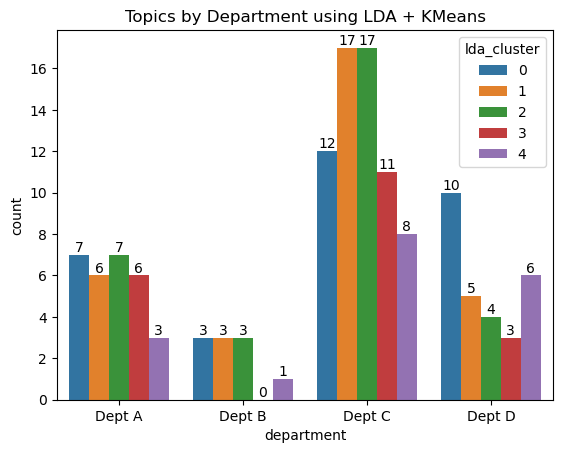

In [11]:
# Plot of topics by department
ax1 = sns.countplot(x ='department', data = data_final, hue="lda_cluster")
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
ax1.bar_label(ax1.containers[2])
ax1.bar_label(ax1.containers[3])
ax1.bar_label(ax1.containers[4])
plt.title("Topics by Department using LDA + KMeans")

#### Observations for LDA
LDA + KMeans is a more simplistic approach - LDA is a BOW approach whereby the context and syntax of the words are taken out and do not have meaning. However, we know that words can be used in different context and a same word can have slightly different meaning

### 3.2 Embedding Based Solution - Doc2Vec + KMeans

Using of embeddings to generate topics. This will help with solving the issue regarding perserving the word syntax

In [84]:
# Create the documents
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(data_final['clean_employee_feedback'])]

# Instantiate model
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# Extract vectors for analysis
vectors = [model.infer_vector(doc.split()) for doc in data_final['clean_employee_feedback']]

# Using KMeans to cluster the vectors (hence, responses)
kmeans = KMeans(n_clusters=5, random_state=2023).fit(vectors)
data_final['topic2vec_cluster'] = kmeans.labels_

# Examine clusters for potential topics
print("Doc2Vec clusters:")
print(data_final[['clean_employee_feedback', 'topic2vec_cluster']])

Doc2Vec clusters:
                               clean_employee_feedback  topic2vec_cluster
0    there culture blame within company make diffic...                  3
1    company approach feedback performance review g...                  3
2    page limit set department ignoring still long ...                  4
4    culture collaboration within team truly someth...                  3
5    workload overwhelming time appreciate company ...                  1
..                                                 ...                ...
150  documentation thorough onboarding new member q...                  1
151  feedback flow freely suggestion improve seen o...                  4
152      team lead example standard set motivate excel                  0
153  crosstraining job shadowing help broaden skill...                  1
154  virtual collaboration tool communication chann...                  1

[132 rows x 2 columns]


/opt/conda/envs/topic-extract/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_11373/3519067645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['topic2vec_cluster'] = kmeans.labels_


Text(0.5, 1.0, 'Topics by Department using Doc2Vec + KMeans')

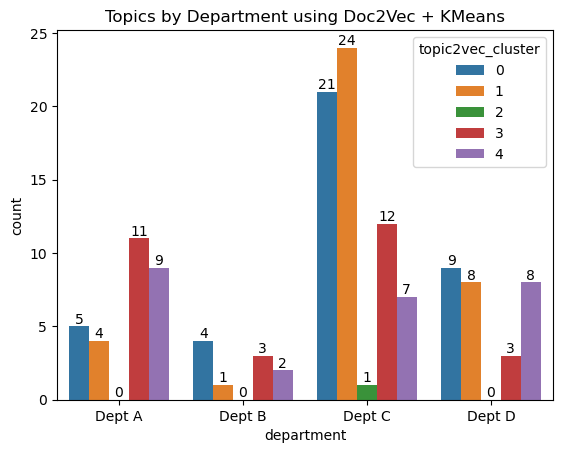

In [85]:
# Plot of topics by department
ax1 = sns.countplot(x ='department', data = data_final, hue="topic2vec_cluster")
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
ax1.bar_label(ax1.containers[2])
ax1.bar_label(ax1.containers[3])
ax1.bar_label(ax1.containers[4])
plt.title("Topics by Department using Doc2Vec + KMeans")

In [18]:
data_final[data_final["topic2vec_cluster"] == 0]

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count,lda_cluster,topic2vec_cluster
15,3192,I appreciate the company's commitment to susta...,Dept A,appreciate company commitment sustainability m...,31,0,0
41,3534,"Relook at benchmarking, investment banks compe...",Dept B,relook benchmarking investment bank compensati...,23,0,0
47,1073,I appreciate the company's efforts to foster a...,Dept B,appreciate company effort foster diverse inclu...,44,0,0
49,7762,Coupled with ever increasing areas of focus an...,Dept B,coupled ever increasing area focus additional ...,23,3,0
51,6179,While the company is committed to transparency...,Dept B,company committed transparency feel like still...,35,0,0
56,2834,The company's commitment to work autonomy has ...,Dept C,company commitment work autonomy instrumental ...,49,0,0
87,3218,I feel empowered to share my thoughts and cont...,Dept C,feel empowered share thought contribute compan...,15,3,0
103,1582,Some training opportunities provided,Dept C,training opportunity provided,4,4,0
110,3841,I have opportunities to learn and grow in my r...,Dept C,opportunity learn grow role,10,4,0
124,7090,1) Immediate managers are available and suppor...,Dept C,immediate manager available supportive however...,40,0,0


### 3.3 Embedding Based Solution - SBERT + DBScan

Convert documents to embeddings via SBERT model. Clusters are form via DBScan (Density-Based Spatial Clustering of Applications with Noise - density based cluster technique that groups data points based on their density and proximity to each other) - documents with underlying similarity are likely similar documents/topics.

Why use DBScan?
1. Groups 'densely grouped' data points into a single cluster
2. Identifies clusters in large spatial datasets by looking at the local density of the data points
3. Robust to outliers 
4. Does not require us to specify the number of clusters beforehand like K-Means

In [61]:
# Instantiate model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [62]:
# Create list of docs
docs = data_final["employee_feedback"].tolist()

In [63]:
# Create embeddings
embeddings = model.encode(docs)

In [64]:
# Cluster using DBSCAN - cluster similar textual data together based on embeddings
dbscan = DBSCAN(eps=0.5, min_samples=3, metric='cosine') # Eps: radius of the circle created around each data point to check the density. Min_samples: min number of datapoints required in that circle for that data point to be classified as a core datapoint
data_final['sbert_cluster'] = dbscan.fit_predict(embeddings)

/tmp/ipykernel_11373/3768110397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['sbert_cluster'] = dbscan.fit_predict(embeddings)


In [67]:
# Sample from each valid cluster
for cluster_num in set(data_final['sbert_cluster']):
    if cluster_num != -1:  # -1 is noise in DBSCAN
        print(f"Sample responses from Cluster {cluster_num}:")
        print(data_final[data_final['sbert_cluster'] == cluster_num]['employee_feedback'])

Sample responses from Cluster 0:
0      There's a culture of blame within the company ...
1      The company's approach to feedback and perform...
4      The culture of collaboration within our team i...
5      While the workload can be overwhelming at time...
8      While the company offers competitive compensat...
                             ...                        
150    Our documentation is thorough. Onboarding new ...
151    Feedback flows freely. Suggestions to improve ...
152    Our team leads by example. The standards they ...
153    Cross-training and job shadowing help broaden ...
154    Virtual collaboration tools and communication ...
Name: employee_feedback, Length: 98, dtype: object
Sample responses from Cluster 1:
93                             Recognition for good work
137    Responsibilities were divided logically based ...
140    Individual contributions are valued. People ar...
Name: employee_feedback, dtype: object


In [68]:
# Check results for cluster 0
data_final[data_final['sbert_cluster'] == 0]

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count,lda_cluster,topic2vec_cluster,sbert_cluster
0,3565,There's a culture of blame within the company ...,Dept A,there culture blame within company make diffic...,25,3,6,0
1,7323,The company's approach to feedback and perform...,Dept A,company approach feedback performance review g...,85,4,3,0
4,2179,The culture of collaboration within our team i...,Dept A,culture collaboration within team truly someth...,57,2,6,0
5,6830,While the workload can be overwhelming at time...,Dept A,workload overwhelming time appreciate company ...,36,1,8,0
8,7594,While the company offers competitive compensat...,Dept A,company offer competitive compensation still a...,40,0,1,0
...,...,...,...,...,...,...,...,...
150,7590,Our documentation is thorough. Onboarding new ...,Dept D,documentation thorough onboarding new member q...,14,4,5,0
151,4622,Feedback flows freely. Suggestions to improve ...,Dept D,feedback flow freely suggestion improve seen o...,12,1,1,0
152,2635,Our team leads by example. The standards they ...,Dept D,team lead example standard set motivate excel,13,0,0,0
153,3272,Cross-training and job shadowing help broaden ...,Dept D,crosstraining job shadowing help broaden skill...,16,0,0,0


In [69]:
# Check results for cluster 1
data_final[data_final['sbert_cluster'] == 1]

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count,lda_cluster,topic2vec_cluster,sbert_cluster
93,2015,Recognition for good work,Dept C,recognition good work,4,0,8,1
137,9568,Responsibilities were divided logically based ...,Dept D,responsibility divided logically based individ...,13,2,3,1
140,4768,Individual contributions are valued. People ar...,Dept D,individual contribution valued people recogniz...,12,1,4,1


Text(0.5, 1.0, 'Topics by Department using SBERT + DBScan')

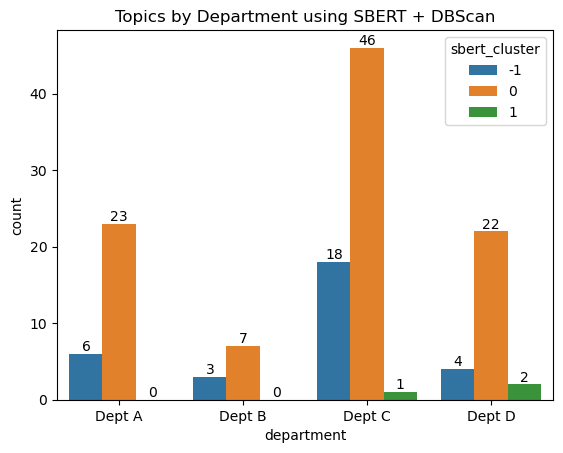

In [86]:
# Plot of topics by department
ax1 = sns.countplot(x ='department', data = data_final, hue="sbert_cluster")
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
ax1.bar_label(ax1.containers[2])
plt.title("Topics by Department using SBERT + DBScan")

#### Observations
1. Two topics group were formed - 0. Company, team culture and compensation 1. Recognition of work
2. Topic 0 seems quite broad as it contains multiple themes
3. Department A and B majority seem to form only topic 0 while department C and D have a few on topic 1

### 3.3 Embedding Based Solution - SBERT + HDBScan

Convert documents to embeddings via SBERT model.Clusters are form via HDBScan (Hierarchical Density-Based Spatial Clustering of Applications with Noise - density based cluster technique that groups data points based on their density and proximity to each other and over varying epsilon values and integrates the results tgo fgind the cluster that gives the best stability over epsilon) - documents with underlying similarity are likely similar documents/topics.

Why use HDBScan?
1. More robust to varying DBScan
2. Good clustering out of the box without miuch parameter tuning
3. Robust to outliers 
4. Does not require us to specify the number of clusters beforehand like K-Means

In [88]:
# Initialise Hdbscan
clusterer = hdbscan.HDBSCAN(min_samples=5, metric='euclidean')
data_final['hdbscan_cluster'] = clusterer.fit_predict(embeddings)

/tmp/ipykernel_11373/4037240294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['hdbscan_cluster'] = clusterer.fit_predict(embeddings)


In [91]:
# Sample from each valid cluster
for cluster_num in set(data_final['hdbscan_cluster']):
    if cluster_num != -1:  # -1 is noise in DBSCAN
        print(f"Sample responses from Cluster {cluster_num}:")
        print(data_final[data_final['hdbscan_cluster'] == cluster_num]['employee_feedback'])

Sample responses from Cluster 0:
1      The company's approach to feedback and perform...
4      The culture of collaboration within our team i...
17     The company's approach to feedback and perform...
20     The leadership team is incredibly communicativ...
26     The company's commitment to professional devel...
38     The company's approach to feedback and perform...
46     The company's culture is generally positive an...
47     I appreciate the company's efforts to foster a...
56     The company's commitment to work autonomy has ...
61     The company's feedback process is helpful, but...
68     The communication within our team is lacking, ...
69     In conclusion, I highly appreciate the company...
79     A few points:\n - The company's culture is gen...
81     I am extremely satisfied with the level of sup...
96                    Managers pay attention to feedback
104        Appreciated efforts towards work-life balance
108                 I am proud to work for this company

Text(0.5, 1.0, 'Topics by Department using SBERT + HDBScan')

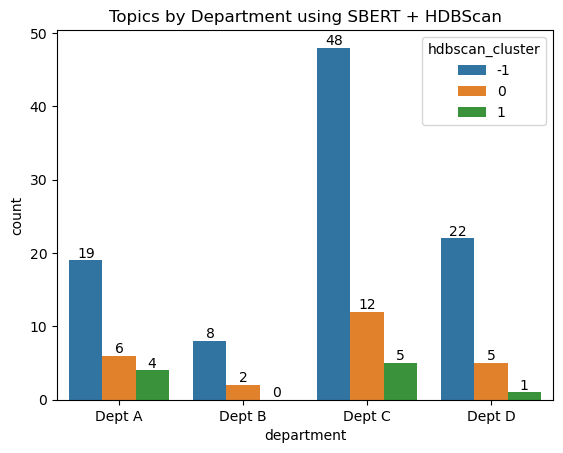

In [90]:
# Plot of topics by department
ax1 = sns.countplot(x ='department', data = data_final, hue="hdbscan_cluster")
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
ax1.bar_label(ax1.containers[2])
plt.title("Topics by Department using SBERT + HDBScan")

In [92]:
# Check results for cluster 0
data_final[data_final['hdbscan_cluster'] == 0]

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count,lda_cluster,topic2vec_cluster,sbert_cluster,hdbscan_cluster
1,7323,The company's approach to feedback and perform...,Dept A,company approach feedback performance review g...,85,4,3,0,0
4,2179,The culture of collaboration within our team i...,Dept A,culture collaboration within team truly someth...,57,2,3,0,0
17,2891,The company's approach to feedback and perform...,Dept A,company approach feedback performance review o...,32,3,4,0,0
20,2937,The leadership team is incredibly communicativ...,Dept A,leadership team incredibly communicative trans...,45,3,3,0,0
26,3205,The company's commitment to professional devel...,Dept A,company commitment professional development re...,53,0,4,0,0
38,2479,The company's approach to feedback and perform...,Dept A,company approach feedback performance review i...,98,0,3,0,0
46,1398,The company's culture is generally positive an...,Dept B,company culture generally positive supportive ...,82,0,4,0,0
47,1073,I appreciate the company's efforts to foster a...,Dept B,appreciate company effort foster diverse inclu...,44,0,0,0,0
56,2834,The company's commitment to work autonomy has ...,Dept C,company commitment work autonomy instrumental ...,49,0,0,0,0
61,2273,"The company's feedback process is helpful, but...",Dept C,company feedback process helpful could frequen...,36,4,0,0,0


In [94]:
# Check results for cluster 1
data_final[data_final['hdbscan_cluster'] == 1]

,unique_identifier,employee_feedback,department,clean_employee_feedback,word_count,lda_cluster,topic2vec_cluster,sbert_cluster,hdbscan_cluster
5,6830,While the workload can be overwhelming at time...,Dept A,workload overwhelming time appreciate company ...,36,1,1,0,1
9,7910,While the company's benefits package is genera...,Dept A,company benefit package generally competitive ...,38,0,3,0,1
28,3070,The company's benefits package is lackluster. ...,Dept A,company benefit package lackluster compared co...,31,2,0,0,1
31,4660,I appreciate the company's commitment to work-...,Dept A,appreciate company commitment worklife balance...,100,4,0,0,1
55,2918,The company's benefits package is pretty stand...,Dept C,company benefit package pretty standard would ...,34,0,0,0,1
59,7850,The work-life balance options here are excelle...,Dept C,worklife balance option excellent whether need...,46,1,0,0,1
60,5109,The company's approach to work-life balance is...,Dept C,company approach worklife balance insufficient...,45,1,1,0,1
66,1472,"I feel like my workload is unreasonable, and I...",Dept C,feel like workload unreasonable often find wor...,34,1,0,0,1
82,4824,While I appreciate the flexibility offered by ...,Dept C,appreciate flexibility offered company sometim...,101,4,3,0,1
127,2743,Work-life balance varies greatly depending on ...,Dept D,worklife balance varies greatly depending team...,38,1,4,0,1


#### Observations
1. Using HDBScan, more data points were found to be noisy as compared to DBScan
2. Two topics group were formed - 0. Company and team culture 1. More towards working culture like workload
3. Department C seems to contain many "noisy" data points (i.e. feedback which we are unable to form a cluster) while Deparment B only contains topics 0.
4. Department A seems to contain an almost equal mix of topic 0 and 1 although it does contain quite a number of noisy data points as well